# Basic Configuration

In [258]:
# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"


# fiudial field coortinate
RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used
    
#Define dither pattern
DITHER_PATTERN = OrderedDict()
#DITHER_PATTERN['A'] = ( 10./3600.,0.)
#DITHER_PATTERN['B'] = (-10./3600.,0.)
#DITHER_PATTERN['C'] = (-10./3600.,0.)
#DITHER_PATTERN['D'] = (-10./3600.,0.)


#BLOCKLENGTH = 300. # block exposure time in s, to simulate three consequtive exposures
BLOCKLENGTH = 900. # block exposure time in s

# dither in a hexagon
a = np.deg2rad( np.arange(0., 360., 60) )
r = 100. 
xx = np.sin(a) * r/3600.
yy = np.cos(a) * r/3600.
for i,(x,y) in enumerate(zip(xx,yy)):
    DITHER_PATTERN['D{:02d}'.format(i) ] = ( x,y)
    
    
# 
if [RA0, DEC0] != [np.nan, np.nan]:
    cRA, cDEC = RA0, DEC0

pointings = OrderedDict()
for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
    pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
    pointings[did] = (pointing_RA, pointing_DEC) 


In [259]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost 
# of non-observation and non-completion as 
# a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (1e4,1e9)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf

# need one calibration star per exposure
supply_dict['cal_P01'] = 11 # force exactly 40
# need one sky positions per exposure
supply_dict['sky_P01'] = 200 # force exactly 240

In [260]:
# You can limit the problem here by constraining it to a subregion of the focal plane

# good very minimal example
RMAX = 10.
CENTER = [-0.,0.]
name="tinytiny"

# check for changing visibility
RMAX = 10.
CENTER = [7.,-12.]
name="tiny"

# intermediate example
RMAX = 150.
CENTER = [0.,0.]
name="intermediate"

# good small example!
RMAX = 25.
CENTER = [-0.,0.]
name="small"

# do them all!
RMAX = 310.
CENTER = [-0.,0.]
name="all"

In [261]:
ENABLE_COLLISION_AVOIDANCE = True # enable endpoint collision avoidance, slow if there is many (>> 10k) targets
PLOT_TARGET_DISTRIBUTION   = True
PLOT_SURVEY_PLAN           = False # plot network of survey plan. Only use when restricting to very small subegions of the focal plane!
PLOT_FOCAL_PLANE           = False # plot focal plane and indicate which cobras observe what targets. 
                                   # Only use when restricting to very small subegions of the focal plane!
    
RANDOM_PRIORITIES          = False # Randomly assign priority classes to sciencetargets 

# Some useful preparation

In [262]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [263]:
from matplotlib import pyplot as plt
%matplotlib inline

In [264]:
def pp(s):
    print(s)
    return s + "\n"

In [265]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")

# Next two lines forc outomatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

# Datamodel for the flow network
import pfs_netflow.datamodel as dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the catalogs, compute visibility ... 

In [274]:
from astropy.io import ascii
import numpy as np

# Load target lists.
science_targets = ascii.read(fscience_targets)
cal_stars = ascii.read(fcal_stars)
sky_pos = ascii.read(fsky_pos)

# find field center and extent
cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )


In [275]:
# Convert data to lists for ETS.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array
from collections import OrderedDict


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{:02d}'.format(t, p)


# limit targets to a smaller field of view
DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane

dra = (ra - cRA)*cos(deg2rad(cDEC))
ddec = dec - cDEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

print( "{} science targets, {} calibration targets, and {} sky positions survive radial cut.".format(sum(ii_sci),sum(ii_cal),sum(ii_sky)))

12531 science targets, 20 calibration targets, and 567 sky positions survive radial cut.


In [276]:
# assign random priorities between 1 and 3 for the  science targets
if RANDOM_PRIORITIES:
    # Kohei's catalog already does come with priorities
    from numpy import random
    from numpy import array

    random.seed(42)

    N =  sum(ii_sci) 

    newpri = array( random.uniform(1.,4., size=N) , dtype=int)
    priorities = np.array(priorities)

    priorities[ii_sci] = newpri
    priorities = priorities.tolist()

In [277]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = max( int(nrv), 1)
    
print( "Unique sequence of required revisits", unique( [v for v in nreqv_dict.values()] ))

Unique sequence of required revisits [1]


In [278]:
# RANDOMISE NUMBER OF REQUIRED VISISTS
RANDOMIZENREQ = False

if RANDOMIZENREQ:
    from numpy import random
    
    NVISITS = 10
    nv = np.floor( random.uniform(NVISITS+1, size=len(ID)) ) 

    # compute number of required visists from exposure times
    # and block length
    nreqv_dict = {}
    for id,t,nrv in zip(ID, types, nv):
        nreqv_dict[id] = int(nrv)

    print( "Required revisits", unique( [v for v in nreqv_dict.values()] ))

In [279]:
import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang+90.,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# for every pointing, compute target positions
# in the focal plane 
# and a visibilty map
visibility_maps = OrderedDict()
ets_target_pos  = OrderedDict()
for pid,(pointing_RA,pointing_DEC) in pointings.items():
    # Parse a target file and return the quantities of interest
    ets_target_pos[pid] = radec2pos(ra, dec, raTel=pointing_RA, decTel=pointing_DEC)

    # get a list of targets, and a list of Cobras that can observe them
    # keys contain object index
    # values contain indices of cobras that can observe that object.
    visibility_maps[pid] = pyETS.getVis(ets_target_pos[pid], ets_cobras)

In [280]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format
from collections import OrderedDict

# obtain cobra centers in old ETS dictionary style
cobras = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][0] ), np.imag( ets_cobras[i][0] )
        cobras["{:d}".format(i)] = [x,y]
        
# obtain dot centers in dictionary style
dots = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][-2] ), np.imag( ets_cobras[i][-2] )
        r = ets_cobras[i][-1]
        dots["{:d}".format(i)] = [x,y,r]


# obtain target positions in old ETS dictionary style
target_fplane_pos = OrderedDict()
for pid in ets_target_pos:
    tt = OrderedDict()
    for j,c in enumerate(ets_target_pos[pid]):
            x,y = np.real(c),np.imag(c)
            tt[ID[j]] = [float(x),float(y)]
    target_fplane_pos[pid] = tt

# obtain visibilities in old ETS dictionary style
visibilities = OrderedDict()
for pid in visibility_maps:
    vv = OrderedDict()   
    for v in visibility_maps[pid]:
        t = ID[v]
        cc = ["{:d}".format(c) for c in visibility_maps[pid][v]]
        vv[t] = cc
    visibilities[pid] = vv    

In [281]:
# This plot the focal plane, with all the target positions at all
# dither positions. Can take very long, shoudl only be done with a subset of the total 
# targets.

def filterFoV(xx,yy, maxx=20., maxy=20.):
    ii  = xx >= -maxx
    ii *= xx <=  maxx
    ii *= yy >= -maxy
    ii *= yy <=  maxy
    return ii

def my_circle_scatter(axes, x_array, y_array, radius, **kwargs):
    for x, y, r in zip(x_array, y_array, radius):
        circle = plt.Circle((x,y), radius=r, edgecolor='k', facecolor='grey', **kwargs)
        axes.add_patch(circle)
    return True

def plotFP(cobras,dots,targets,maxx=20.,maxy=20.):
    
    f = plt.figure(figsize=[10,10])
    ax = plt.subplot(1,1,1)
    
    # rearrange dot and cobra information for easy plotting
    dxx = np.array( [d[0] for did, d in dots.items()] )
    dyy = np.array( [d[1] for did, d in dots.items()] )
    drr = np.array( [d[2] for did, d in dots.items()] )
    ciddd = np.array( [did for did, d in dots.items()] )

    cxx = np.array( [c[0] for cid, c in cobras.items()] )
    cyy = np.array( [c[1] for cid, c in cobras.items()] )
    ciddd = np.array( [cid for cid, t in cobras.items()] )
    
    # plot cobras
    ii = filterFoV(cxx,cyy,maxx=maxx,maxy=maxy)
    plt.plot(cxx[ii],cyy[ii],'.', c='orange')
    ii = filterFoV(cxx,cyy )
    for x,y,l in zip(cxx[ii],cyy[ii],ciddd[ii]):
        plt.text(x,y,l)

    # plot dots
    ii = filterFoV(dxx,dyy,maxx=maxx,maxy=maxy)
    my_circle_scatter(ax, dxx[ii],dyy[ii], drr[ii] )
    

    N = len(target_fplane_pos)
    for i,pid in enumerate(target_fplane_pos):
        alpha = 1. - float(i)/float( N )

        # rearrange target information for easy plotting
        txx = np.array( [t[0] for tid, t in target_fplane_pos[pid].items()] )
        tyy = np.array( [t[1] for tid, t in target_fplane_pos[pid].items()] )
        tiddd = np.array( [tid for tid, t in target_fplane_pos[pid].items()] )

        # plot targets
        ii = filterFoV(txx,tyy,maxx=maxx,maxy=maxy)
        plt.plot(txx[ii],tyy[ii],'bo', alpha=alpha, label='pointing {}'.format(pid))

        for x,y,l in zip(txx[ii],tyy[ii],tiddd[ii]):
            plt.text(x,y,l, size=8)

        # plot visibility arcs
        if True:
            for tid,cc in visibilities[pid].items():
                tx,ty = target_fplane_pos[pid][tid]
                for c in cc:
                    cx,cy = cobras[c]
                    #print c
                    #plt.text(cx,cy,"{}".format(c) )
                    plt.plot([cx,tx],[cy,ty],'k-', alpha=alpha)


        
            
       #plt.text(zip(txx[ii],tyy[ii]),tiddd[ii], size=6)   

    plt.axis('equal')
    plt.xlim([-maxx,maxx])
    plt.ylim([-maxy,maxy])
    plt.legend()
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    
#plotFP(cobras,dots,target_fplane_pos,maxx=20.,maxy=20.)

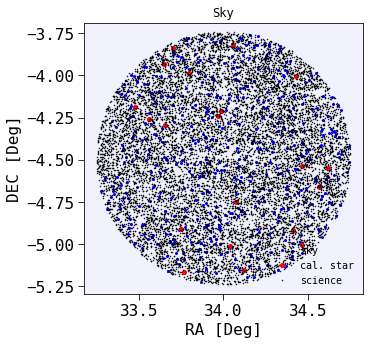

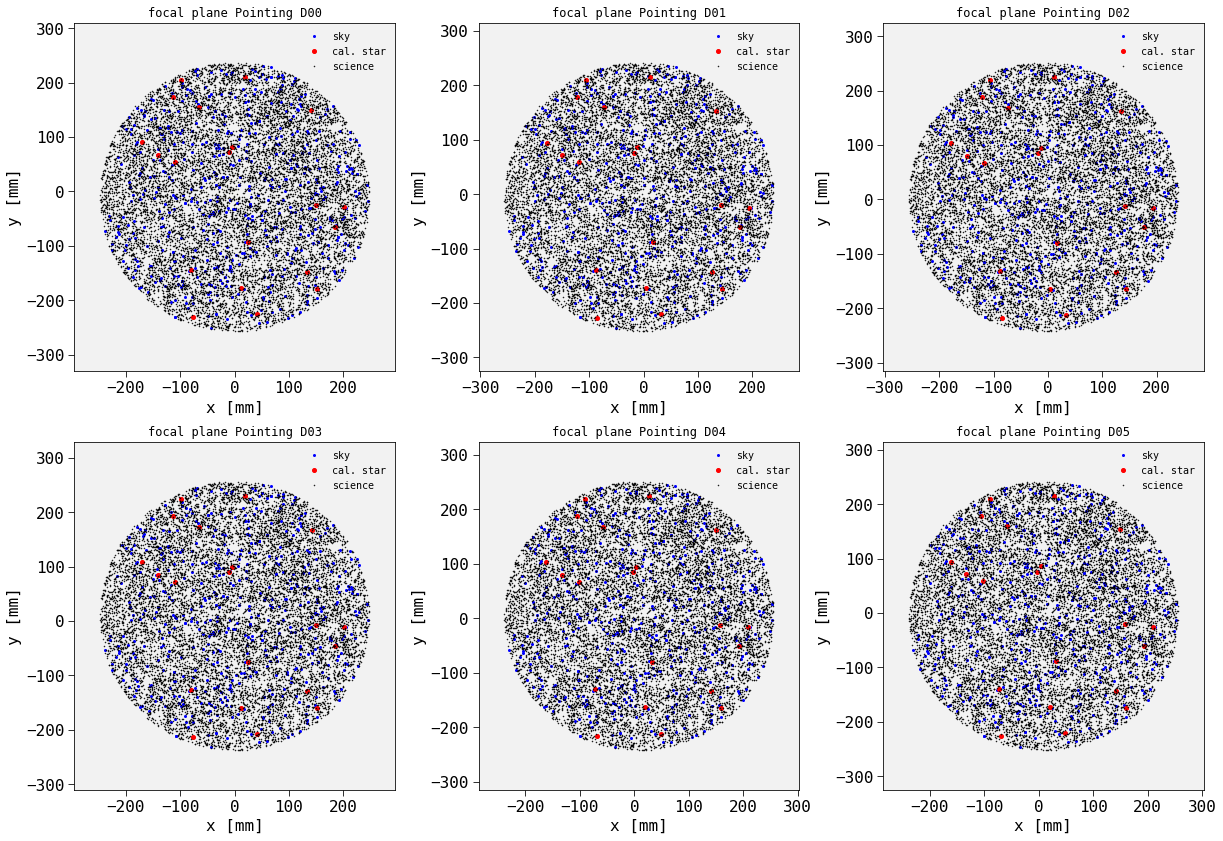

In [282]:
if PLOT_TARGET_DISTRIBUTION:
    from pfs_netflow.plotting import plotTargetDistribution
    plotTargetDistribution(ra, dec, types, pointings, target_fplane_pos, class_dict)

# Collisions

In [283]:
from scipy.spatial.distance import cdist

PLOT = False

# find collision pairs
fiber_collision_radius = 1.
        
# I am sure this code cound be massively optimized by subdeviding the focal plane
# also we probably don't need to do this on a per-pointing basis.
collision_pairs = OrderedDict()

if ENABLE_COLLISION_AVOIDANCE:
    for pid,(pointing_RA,pointing_DEC) in pointings.items():

        targets = target_fplane_pos[pid]
        tclasses = [class_dict[tid] for tid in target_fplane_pos[pid]]

        txx = np.array( [t[0] for tid, t in targets.items()] )
        tyy = np.array( [t[1] for tid, t in targets.items()] )

        _ii_sci = list( map( lambda x : x.startswith('sci') , tclasses ) )
        _ii_sky = list( map( lambda x : x.startswith('sky') , tclasses ) ) 
        _ii_cal = list( map( lambda x : x.startswith('cal') , tclasses ) )

        if PLOT:
            f = plt.figure(figsize=[5,5])
            plt.subplot()
            plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
            plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
            plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


        N = len(ID)
        points = list( zip(txx,tyy) )
        Y = cdist( points[:N], points[:N] )

        # any target separation that is smaller than 2 x the collision radius will be flagged a s collision
        cc = Y <= (fiber_collision_radius*2.) 
        ncoll = int( (np.sum(cc.flatten()) - N)/2. )

        print ("Pointing {}: Found  {:d} collision pairs.".format( pid, ncoll  ))

        # identify collision pairs
        collision_pairs[pid] = []
        # array of indices
        ii = np.arange(N)
        for i in range(cc.shape[0]):
            x1,y1 =  txx[i], tyy[i]
            # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
            jj = ii[ cc[i,:] * ii > i ] 
            for j in jj: 
                if cc[i,j]:
                    x2,y2 =  txx[j], tyy[j]
                    collision_pairs[pid].append([(ID[i],x1,y1),(ID[j],x2,y2)])


        if PLOT:
            for cp in collision_pairs[pid]:
                plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')


            plt.axis('equal')
            l = plt.legend()
            l.draw_frame(False)
            plt.xlabel("x [mm]")
            plt.ylabel("y [mm]")
            plt.xlim([-15,15])

Pointing D00: Found  6043 collision pairs.
Pointing D01: Found  6036 collision pairs.
Pointing D02: Found  6040 collision pairs.
Pointing D03: Found  6042 collision pairs.
Pointing D04: Found  6040 collision pairs.
Pointing D05: Found  6042 collision pairs.


# Invert visibilities

In [284]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = OrderedDict()
    for pid in visibilities:
        cnt = 0
        ivisibilities[pid] = OrderedDict()
        for v in visibilities[pid]:
            t = v
            cc = visibilities[pid][v]

            for c in cc:
                if c in ivisibilities[pid]:
                    ivisibilities[pid][c].append(v)
                else:
                    ivisibilities[pid][c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)           

In [285]:
for pid in visibilities:
    print("Pointing {}".format(pid))
    nsci_observable = 0
    ncal_observable = 0
    nsky_observable = 0

    for tid,v in visibilities[pid].items():
        if len(v) > 0:
            if class_dict[tid][:3] == 'cal':
                ncal_observable += 1
            elif class_dict[tid][:3] == 'sky':
                nsky_observable += 1
            elif class_dict[tid][:3] == 'sci':
                nsci_observable += 1
            #break


    print("{} targets positions in total.".format(sum(ii_sci) ))
    print("{} cal. targets in total.".format(sum(ii_cal) ))
    print("{} sky positions in total.".format(sum(ii_sky) ))
    print("{} cobras have at least one target in reach.".format(len(ivisibilities[pid])))
    print("{} science targets\n{} calibration targets, \
    and \n{} sky positions are in reach of at least one cobra.".format(nsci_observable, ncal_observable, nsky_observable))  
    print("")

Pointing D00
12531 targets positions in total.
20 cal. targets in total.
567 sky positions in total.
2349 cobras have at least one target in reach.
8078 science targets
13 calibration targets,     and 
383 sky positions are in reach of at least one cobra.

Pointing D01
12531 targets positions in total.
20 cal. targets in total.
567 sky positions in total.
2344 cobras have at least one target in reach.
8044 science targets
14 calibration targets,     and 
379 sky positions are in reach of at least one cobra.

Pointing D02
12531 targets positions in total.
20 cal. targets in total.
567 sky positions in total.
2354 cobras have at least one target in reach.
8100 science targets
11 calibration targets,     and 
370 sky positions are in reach of at least one cobra.

Pointing D03
12531 targets positions in total.
20 cal. targets in total.
567 sky positions in total.
2348 cobras have at least one target in reach.
8058 science targets
12 calibration targets,     and 
361 sky positions are in re

# Execute netflow

In [287]:
# Build the survey plan graph.

from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

print("Creating graph ...")

# for per-ponting list of targets, build
# single list of targets with multiple entries for the focal plane positions
targets = OrderedDict()
for pid in target_fplane_pos:
    tt = target_fplane_pos[pid] 
    for tid in tt:
        x,y = tt[tid]
        if not tid in targets:
             targets[tid] = OrderedDict()
        targets[tid][pid] = (x,y)
        

# build the survey plan graph
g = buildSurveyPlan(cobras, targets, nreqv_dict, visibilities, class_dict,\
                    cost_dict, supply_dict, RMAX, CENTER=(0.,0.), COBRAS=[])

print("Done.")

for pid in pointings:
    print("Pointing {}".format(pid))
    for c in g.sciTargetClasses:

        nsci = 0
        nsci_reachable = 0
        for t in g.sciTargetClasses[c].targets.values():
            if t.outarcs != []:
                nsci += 1
                nsci_reachable += 1

        print("   Number of targets in {} is {}.".format(c, nsci ) )
        print("   Number of observable targets in {} is {}.".format(c, nsci_reachable ) )


    ncal = 0
    ncal_reachable = 0
    for t in g.calTargetClasses['TClass_cal_P01_v{}'.format(pid)].targets.values():
        if t.outarcs != []:
            ncal += 1
            ncal_reachable += 1
    print("   Number of calibration stars: {}".format(ncal) )
    print("   Number of observable calibration stars: {}".format( ncal_reachable )) 


    nsky = 0
    nsky_reachable = 0
    for t in g.calTargetClasses['TClass_sky_P01_v{}'.format(pid)].targets.values():
        if t. outarcs != []:
            nsky += 1
            nsky_reachable += 1
    print("   Number of sky positions: {}".format(nsky) )
    print("   Number of observable sky positions: {}".format(nsky_reachable) )



Creating graph ...
buildSurveyPlan
Done.
Pointing D00
   Number of targets in TClass_sci_P01 is 12531.
   Number of observable targets in TClass_sci_P01 is 12531.
   Number of calibration stars: 13
   Number of observable calibration stars: 13
   Number of sky positions: 383
   Number of observable sky positions: 383
Pointing D01
   Number of targets in TClass_sci_P01 is 12531.
   Number of observable targets in TClass_sci_P01 is 12531.
   Number of calibration stars: 14
   Number of observable calibration stars: 14
   Number of sky positions: 379
   Number of observable sky positions: 379
Pointing D02
   Number of targets in TClass_sci_P01 is 12531.
   Number of observable targets in TClass_sci_P01 is 12531.
   Number of calibration stars: 11
   Number of observable calibration stars: 11
   Number of sky positions: 370
   Number of observable sky positions: 370
Pointing D03
   Number of targets in TClass_sci_P01 is 12531.
   Number of observable targets in TClass_sci_P01 is 12531.
   

In [288]:
# now build the LP problem
from pfs_netflow.lp import buildLPProblem, solve
from pulp import LpStatus, value
import time


def setflows(g,flows):
    for a in g.arcs.values():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if k in flows:
            a.flow = value(flows[k])


    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)
NVISITS = len( g.visits )

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(int(NCalTargets/NVISITS) ))
summary += pp(" {} cobras".format(NCobras))
summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g, cat='Integer')
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

__ = prob.writeMPS("mps/{}_{}_{}.mps".format(name, RMAX, NVISITS), rename=1)

NVISITS = 6
Searching optimal strategy to observe in 
 6 visits
 12531 science targets
 587 calib. targets
 2394 cobras
num nodes: 108011
num edges: 183176
Building LP problem ...
Building cost equation ...
 Time to completion: 7.29 s
Time to build model: 8.0278e+00 s


In [289]:
import pulp
from pfs_netflow.survey_plan import compute_collision_flow_pairs
  
if ENABLE_COLLISION_AVOIDANCE:
    flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
    print("Adding {} collision avoidance constraints.".format(len(flow_pairs)))              
    for fp in flow_pairs:
        prob += pulp.lpSum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1.

__ = prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq_colldetect.mps".format(name,NVISITS), rename=1)

Adding 217458 collision avoidance constraints.


In [290]:
from numpy import random

# solve it!

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()

#maxSeconds=2400.
#status = solve(prob, maxSeconds=maxSeconds)
status = solve(prob, solver="GUROBI")


time_to_solve = time.time() - start_time
summary += pp("Solve status is [{}].".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))


Solving LP problem ...
Optimize a model with 323075 rows, 183177 columns and 849560 nonzeros
Variable types: 1 continuous, 183176 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+12]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 294753 rows and 123653 columns
Presolve time: 1.40s
Presolved: 28322 rows, 59524 columns, 143454 nonzeros
Variable types: 0 continuous, 59524 integer (59501 binary)
Found heuristic solution: objective 1.239000e+15

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Presolve removed 1 rows and 16 columns
Presolved: 28321 rows, 59508 columns, 143432 nonzeros

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: objective 3.195708e+07, 42291 iterations, 0.62 seconds

    Nodes    |    Current Node    |  

In [291]:
from pfs_netflow.survey_plan import computeStats

stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats['cost']) ) )
summary += pp("[{}] out of {} science targets get observed.".format(int(stats['NSciObs']) ,NSciTargets) )
summary += pp("For {} out of these all required exposures got allocated.".format(stats['NSciComplete']))  
summary += pp("Per target class completion:")
                                                            
summary += pp("   {:15s} {:10s} {:10s} {:10s}".format('class', 'total', 'observed', 'completed') )
for tc,compl in stats['completion'].items():
    summary += pp("   {:15s} {:10d} {:10d} {:10d}".format(tc, compl['total'],compl['observed'],compl['completed']))                                                                       
    #print(tc, compl)                                                                  
summary += pp("{} targets get sent down the overflow arc.".format(stats['Noverflow']))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats['Ncobras_used'], NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats['Ncobras_fully_used']))

setflows(g,flows)

Value of cost function = 31962070.0
[9352] out of 12531 science targets get observed.
For 9352 out of these all required exposures got allocated.
Per target class completion:
   class           total      observed   completed 
   TClass_sci_P01       12531       9352       9352
3179 targets get sent down the overflow arc.
2394 out of 2394 cobras observed a target in one or more exposures.
291 cobras observed a target in all exposures.


In [292]:
# test if really no colliding targets were observed
# This needs to be added to the survey plan and buildLPProblem methods.
#
import pulp
from pulp import value

flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
 
NCOLL = 0
for fp in flow_pairs:
    
    if value( flows[ fp[0] ] ) > 0. and value( flows[ fp[1] ] ) > 0.:
        #print("{} {} in collision".format(fp[0],fp[1]))
        NCOLL += 1
                             
print("Detected {} endpoint collisions".format(NCOLL))

Detected 0 endpoint collisions


In [293]:
if PLOT_SURVEY_PLAN:
    plotSurveyPlan(g)

In [294]:
if PLOT_FOCAL_PLANE:
    from pfs_netflow.plotting import plotFocalPlane
    for pid in pointings:
        plotFocalPlane(g, pid=pid, W=30, XC=0., YC=0., name="", figsize=[5,5])


Computing target completion ...
Pointing D00
Pointing D01
Pointing D02
Pointing D03
Pointing D04
Pointing D05
Done, write stats.txt.
 V  nsci ncal nsky nsci_obs ncal_obs nsky_obs nsci_cum
--- ---- ---- ---- -------- -------- -------- --------
D00 2137   11  200     8078       13      383     2137
D01 2075   11  200     8044       14      379     4212
D02 1994   11  200     8100       11      370     6206
D03 1731   11  200     8058       12      361     7937
D04 1124   11  200     8083       12      366     9061
D05  291   11  200     8106       12      369     9352
12531 targets positions in total.
20 cal. targets in total.
567 sky positions in total.


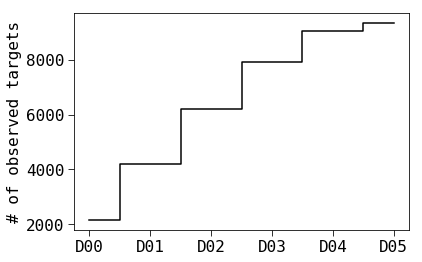

In [295]:
# Performace evaluation: Observed targets vs. number of visits

from astropy.io import ascii
from pfs_netflow import survey_plan as sp

sp.computeTargetCompletion(g, visibilities, class_dict, "stats.txt")

t = ascii.read("stats.txt")
print(t)

f = plt.figure()
plt.plot(t['nsci_cum'], drawstyle='steps-mid')
plt.xticks(np.arange(len(t)),t['V'])
plt.ylabel("# of observed targets")

##

nsci = sum( [class_dict[t][:3] == "sci" for t in targets] )
ncal = sum( [class_dict[t][:3] == "cal" for t in targets] )
nsky = sum( [class_dict[t][:3] == "sky" for t in targets] )

sum( [class_dict[t][:3] == "cal" for t in targets] )


print("{} targets positions in total.".format( nsci ))
print("{} cal. targets in total.".format( ncal ))
print("{} sky positions in total.".format( nsky ))

mn_movedist =  3.112mm
min_movedist = 0.067mm
max_movedist = 4.750mm
std_movedist = 1.223mm
cost from moves = 0.0


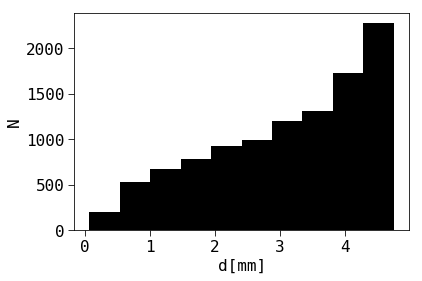

In [296]:
# Statistics on cobra motion

# array of all distances for all possible target/cobra pairs
dd =  np.array( [ a.d for a in g.targetVisitToCobraVisitArcs.values()] )
# array of flows for all possible target/cobra pairs
ff =  np.array( [ value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.values()] )

# caclulate mean cobra move distance
ii = ff > 0.
mn_movedist = np.mean( dd[ii] )
min_movedist = np.min( dd[ii] )
max_movedist = np.max( dd[ii] )
std_movedist = np.std( dd[ii] )

print("mn_movedist =  {:.3f}mm".format(mn_movedist) )
print("min_movedist = {:.3f}mm".format(min_movedist) )
print("max_movedist = {:.3f}mm".format(max_movedist) )
print("std_movedist = {:.3f}mm".format(std_movedist) )

cm = np.sum([ a.cost * value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.values() ])

print("cost from moves = {}".format(cm) )


plt.hist( dd[ii] )
plt.xlabel("d[mm]")
plt.ylabel("N")

# prepare Cobra/Target pairs to run trajectory collision detection

In [ ]:
visit = 0
 
# initialize assigment list with Null
# as required by the collision simulator code.
assignments = OrderedDict()
for c in g.cobras.itervalues():
    assignments[c.id] = 'Null'

# Now find which cobras have been assigned to which targets. 
# Loop over all targetVisit to CobraVisit arcs.Filter for those that correspond to the current visit.
for a in filter(lambda x : x.visit == visit, g.targetVisitToCobraVisitArcs.itervalues()):
    
    if a.flow > 0.:
        t = a.startnode.target
        c = a.endnode.cobra 
        assignments[c.id] = t.id
        
for cid,tid in assignments.iteritems():
    print("{:6s} observes {:10s}".format(cid, tid))


In [ ]:
# feed to collision code
import numpy as np
import time as time

import sys
sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

import ics.cobraOps.plotUtils as plotUtils
import ics.cobraOps.targetUtils as targetUtils

from ics.cobraOps.Bench import Bench
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector
from ics.cobraOps.RandomTargetSelector import RandomTargetSelector

# Create the bench instanceroduct)
#bench = Bench(layout="full", calibrationProduct=calibrationP
cpos = [ [ complex(g.cobras[cid].x , g.cobras[cid].y) ] for cid in assignments]
bench = Bench(cobraCenters=np.array( cpos ))

print("Number of cobras:", bench.cobras.nCobras)

In [ ]:
# Calculate the total number of targets based on the bench properties
    medianPatrolAreaRadius = np.median(bench.cobras.rMax)

    
    nTargets = int(np.ceil(density * (bench.radius / medianPatrolAreaRadius) ** 2))
    
    # Calculate the uniformly distributed target positions
    ang = 2 * np.pi * np.random.random(nTargets)
    radius = bench.radius * np.sqrt(np.random.random(nTargets))
    targetPositions = bench.center + radius * np.exp(1j * ang)
    
    return TargetGroup(targetPositions)

In [ ]:
# Generate the targets
targets = targetUtils.generateRandomTargets(targetDensity, bench)
print("Number of simulated targets:", targets.nTargets)

# Select the targets
selector = DistanceTargetSelector(bench, targets)
selector.run()
selectedTargets = selector.getSelectedTargets()

# Simulate an observation
start = time.time()
simulator = CollisionSimulator(bench, selectedTargets)
simulator.run()
print("Number of cobras involved in collisions:", simulator.nCollisions)
print("Number of cobras unaffected by end collisions: ", simulator.nCollisions - simulator.nEndPointCollisions)
print("Total simulation time (s):", time.time() - start)

# performance comparison ETS vs. netflow

In [ ]:
from astropy.io import ascii

nwf_results_nvisits = {}
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
nwf_results_nvisits[10] = ascii.read("nwf_results_nvisits10_early_obs1.txt")
#nwf_results_nvisits[9] = ascii.read("nwf_results_nvisits9.txt")
#nwf_results_nvisits[8] = ascii.read("nwf_results_nvisits8.txt")
#nwf_results_nvisits[7] = ascii.read("nwf_results_nvisits7.txt")
#nwf_results_nvisits[6] = ascii.read("nwf_results_nvisits6.txt")
#nwf_results_nvisits[5] = ascii.read("nwf_results_nvisits5.txt")
#nwf_results_nvisits[4] = ascii.read("nwf_results_nvisits4.txt")
#nwf_results_nvisits[3] = ascii.read("nwf_results_nvisits3.txt")
#nwf_results_nvisits[2] = ascii.read("nwf_results_nvisits2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

f = plt.figure(figsize=[8,8])

for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)

#for nvisits in nwf_results_nvisits:
#    plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

nvisits = 10
plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label="netflow", color='grey', ms=8)

l = plt.legend()
l.draw_frame(False)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("visit")
plt.ylim([500,8200])

# New & auxiliary stuff

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.itervalues():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if flows.has_key(k):
        allflows.append(value(flows[k]))

print("All flows are: integer {}".format(all( unique(allflows)%1 == 0 )))


In [246]:
# This is awsome rescue code. Ever found yourself deleing a call that had a 
# function implemented that you have been working on for hours?
# This is how you recover it.
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

# Old stuff, just remaining as backup

In [192]:
def computeStatsOld(g, flows, cost):
    stats = OrderedDict()

    NSciObs = 0
    NSciComplete = 0
    NCalObs = np.nan
    NCalComplete = np.nan
    NVISITS = len(g.visits)

    for t in g.sciTargets.values():
        NSciObs += pulp.value(sum([flows[a.id] for a in t.inarcs]))
        NSciComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
    Noverflow = 0
    for tcid, tc in g.sciTargetClasses.items():
        Noverflow += int( pulp.value(flows['{}=SINK'.format(tcid)]) )

    Ncobras_used = 0
    Ncobras_fully_used = 0
    for c in g.cobras.values():
        v = pulp.value(sum([flows[a.id] for a in c.inarcs]))
        Ncobras_used += int(v > 0)
        Ncobras_fully_used += int(v == NVISITS)
        
    stats['cost'] = pulp.value(cost)
    stats['NSciObs'] = NSciObs
    #stats['NCalObs'] = NCalObs
    stats['NSciComplete'] = NSciComplete
    #stats['NCalComplete'] = NCalComplete
    stats['Noverflow'] = Noverflow
    stats['Ncobras_used'] = Ncobras_used
    stats['Ncobras_fully_used'] =  Ncobras_fully_used
    

    compl = {}
    for stc in g.sciTargetClasses.values():
        _NObs = 0
        _NComplete = 0
        for t in stc.targets.values(): 
            _NObs += int( pulp.value(sum([flows[a.id] for a in t.inarcs])) )
            _NComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
        compl[stc.ID] = {'total' : len(stc.targets), 'observed' : _NObs, 'completed' : _NComplete}


    stats['completion'] = compl

    return stats
